In [2]:
import pickle
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.corpus import stopwords
from nltk.stem import porter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
import os
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

In [12]:
true_df = pickle.load(open("pickle_files/true_df.pkl", "rb" ))

In [25]:
true_df.source.unique()

array(['Reuters', 'Breitbart', 'Huffington Post', 'Info wars',
       'Mother Jones', 'National Review', 'Alabama Today',
       'Activist Post', 'Daily Beast', 'Global Research',
       'Associate Press', 'Fox News'], dtype=object)

In [26]:
left = ['Huffington Post', 'Mother Jones', 'Daily Beast']
right = ['Breitbart', 'Info wars', 'Fox News', 'National Review']
center = ['Reuters', 'Associate Press', 'Alabama Today']
fake = ['Info wars', 'Global Research', 'Activist Post']

In [27]:
huffpo_mask = true_df['source'] == 'Huffington Post'
MJ_mask = true_df['source'] == 'Mother Jones' 
DB_mask = true_df['source'] == 'Daily Beast'
huffpo_df = true_df[huffpo_mask]
MJ_df = true_df[MJ_mask]
DB_df = true_df[DB_mask]
left_df = pd.concat([huffpo_df, MJ_df, DB_df])

In [28]:
huffpo_mask = true_df['source'] == 'Breitbart'
MJ_mask = true_df['source'] == 'Info wars' 
DB_mask = true_df['source'] == 'Fox News'
NR_mask = true_df['source'] == 'National Review'
huffpo_df = true_df[huffpo_mask]
MJ_df = true_df[MJ_mask]
DB_df = true_df[DB_mask]
NR_df = true_df[NR_mask]
right_df = pd.concat([huffpo_df, MJ_df, DB_df, NR_df])

In [29]:
huffpo_mask = true_df['source'] == 'Reuters'
MJ_mask = true_df['source'] == 'Associate Press' 
DB_mask = true_df['source'] == 'Alabama Today'
huffpo_df = true_df[huffpo_mask]
MJ_df = true_df[MJ_mask]
DB_df = true_df[DB_mask]
center_df = pd.concat([huffpo_df, MJ_df, DB_df])

In [30]:
huffpo_mask = true_df['source'] == 'Info wars'
MJ_mask = true_df['source'] == 'Global Research' 
DB_mask = true_df['source'] == 'Activist Post'
huffpo_df = true_df[huffpo_mask]
MJ_df = true_df[MJ_mask]
DB_df = true_df[DB_mask]
fake_df = pd.concat([huffpo_df, MJ_df, DB_df])

## Left df topic model

In [31]:
stemmer = porter.PorterStemmer()
stopwords = stopwords.words()

In [32]:
def clean_text(text):
    '''Removes stop words and changes word to stem words'''
    cleaned_text = []
    for post in text:
        cleaned_words = []
        for word in post.split():
            low_word = stemmer.stem(word.lower())
            if low_word not in stopwords:
                cleaned_words.append(low_word)
        cleaned_text.append(' '.join(cleaned_words))
    return cleaned_text

In [33]:
cleaned_text = clean_text(left_df.body)

In [38]:
def drop_nouns(text_list):
    no_nouns = []
    cleaned_text = []
    all_nouns = ['NN' or 'NNS' or 'NNP' or 'NNPS']
    for x in text_list:
        words = pos_tag(word_tokenize(x))
        #werdz = [s for s in words if s[-1] != 'NN']# or 'NNS' or 'NNP' or 'NNPS']
        #werdz = [s for s in werdz if s[-1] != 'NNS']
        #werdz2 = ['NNPS', 'NNP', 'NN', 'NNS', 'JJ', 'JJS', 'JJR', 'VB', 'VB', 'VBD', 'VBG', 'VBN', 'VBN', 'VBP', 'VBZ']
        werdz2 = (['CC','CD','DT','EX','FW','IN','LS','MD','PDT','POS','PRP','PRP$',
                   'RP','TO','UH','WDT','WP','WP$','WRB', 'NNP', 'NNPS', 'NN', 'NNS', 'JJ', ',', '.', ':', '(', ')'])
        werdz = [s for s in words if s[-1] not in werdz2]
        #werdz2 = [s for s, pos in words if pos != 'NNP']
        '''werdz = [s for s in werdz if s[-1] != ',']
        werdz = [s for s in werdz if s[-1] != '.']
        werdz = [s for s in werdz if s[-1] != ':']
        werdz = [s for s in werdz if s[-1] != 'CD']
        werdz = [s for s in werdz if s[-1] != '(']
        werdz = [s for s in werdz if s[-1] != ')']'''
        say_no = ['@','[', ']', 'amp', 'window', 'open','click', 'googletag', 'gpt', 'linkitem', 'googletag', 'getelementbyid',
        'config', 'ldadinit', 'advertis', 'typeof', 'adsdiv', 'fjs', 'js', 'http', 'com', 'awr', 'new', 'function', 'div',
        'ad', 'script', 'typeof', 'nr_is_logged_in', 'undefined', 'adsdiv', 'sharebox_260x60', 'ifr', 'jwplayer', 'jwp',
        'pubdate', 'adunit', 'adwidth', 'www', 'bit.ly/2jpexyr', 'googletag.cmd.push', 'googletag.display', '\'div-gpt-ad-1415299254516-0 \'']
        werdz = [s[-2] for s in werdz if s[-2] not in say_no]
        '''werdz = [s[-2] for s in werdz if s[-2] != '@']
        werdz = [s for s in werdz if s != '[']
        werdz = [s for s in werdz if s != ']']
        werdz = [s for s in werdz if s != 'amp']
        werdz = [s for s in werdz if s != 'window']
        werdz = [s for s in werdz if s != 'open']
        werdz = [s for s in werdz if s != 'click']
        werdz = [s for s in werdz if s != 'googletag']
        werdz = [s for s in werdz if s != 'gpt']
        werdz = [s for s in werdz if s != 'linkitem']
        werdz = [s for s in werdz if s != 'googletag']
        werdz = [s for s in werdz if s != 'getelementbyid']
        werdz = [s for s in werdz if s != 'config']
        werdz = [s for s in werdz if s != 'ldadinit']
        werdz = [s for s in werdz if s != 'advertis']
        werdz = [s for s in werdz if s != 'typeof']
        werdz = [s for s in werdz if s != 'adsdiv']
        werdz = [s for s in werdz if s != 'fjs']
        werdz = [s for s in werdz if s != 'js']
        werdz = [s for s in werdz if s != 'http']
        werdz = [s for s in werdz if s != 'com']
        werdz = [s for s in werdz if s != 'awr']
        werdz = [s for s in werdz if s != 'new']
        werdz = [s for s in werdz if s != 'function']
        werdz = [s for s in werdz if s != 'div']
        werdz = [s for s in werdz if s != 'ad']
        werdz = [s for s in werdz if s != 'script']
        werdz = [s for s in werdz if s != 'typeof']
        werdz = [s for s in werdz if s != 'nr_is_logged_in']
        werdz = [s for s in werdz if s != 'undefined']
        werdz = [s for s in werdz if s != 'adsdiv']
        werdz = [s for s in werdz if s != 'sharebox_260x60']
        werdz = [s for s in werdz if s != 'ifr']
        werdz = [s for s in werdz if s != 'jwplayer']
        werdz = [s for s in werdz if s != 'jwp']
        werdz = [s for s in werdz if s != 'pubdate']
        werdz = [s for s in werdz if s != 'adunit']
        werdz = [s for s in werdz if s != 'adwidth']
        werdz = [s for s in werdz if s != 'www']
        werdz = [s for s in werdz if s != 'origadsplid']
        werdz = [s for s in werdz if s != 'https']
        werdz = [s for s in werdz if s != 'adsbygoogl']
        #werdz = [s for s in werdz if s != 'bit.ly/2jbh4lu']'''
        #check cleaned text line from function above
        no_nouns.append(' '.join(werdz))
        #no_nouns.append(werdz)
    return no_nouns

In [39]:
left_corpus = drop_nouns(cleaned_text)

In [40]:
#left_corpus

In [41]:
tfidf = TfidfVectorizer(ngram_range=(1, 2),  
                                   stop_words='english', 
                                   token_pattern="\\b[a-z][a-z]+\\b",
                                   lowercase=True,
                                   max_df = 0.6)
cor_tfidf = tfidf.fit_transform(left_corpus)

In [42]:
lsa = TruncatedSVD(60, algorithm = 'arpack')
corpus_lsa = lsa.fit_transform(cor_tfidf)
corpus_lsa = Normalizer(copy=False).fit_transform(corpus_lsa)

In [43]:
sum(lsa.explained_variance_ratio_)

0.1299871230970032

In [44]:
terms = tfidf.get_feature_names()

In [45]:
for i, comp in enumerate(lsa.components_):
    Terms_in_Comp = zip(terms,comp)
    sorted_Terms = sorted(Terms_in_Comp, key = lambda x: x[1], reverse=True) [:10]
    print("Topic %d:" %i)
    for term in sorted_Terms:
        print(term[0])
    print(" ")

Topic 0:
undefined
window
box
say
style
adsdiv
adsdiv reloadcount
elem
reloadcount
undefined window
 
Topic 1:
undefined
window
box
style
adsdiv
adsdiv reloadcount
elem
reloadcount
undefined window
box style
 
Topic 2:
april
teacher
look
april april
higher
fake
kentucki
say april
kill
april say
 
Topic 3:
run
says
say
democrat
win
think
elect
west
make
need
 
Topic 4:
april
think
know
don
don know
bi
know bi
agre subscrib
bi agre
subscrib
 
Topic 5:
run
democrat
wrote
elect
agre
digest
agre subscrib
bi agre
subscrib
subscrib digest
 
Topic 6:
told
run
think
democrat
said said
don
elect
seen
told said
huffpost
 
Topic 7:
wrote
love
make
love love
assured
need
think
wrote wrote
hard
overtim
 
Topic 8:
teacher
west
told
wa
make
arizona
educ
king
right
better
 
Topic 9:
wa
told
west
say
love
kill
run
says
teacher
twitter
 
Topic 10:
wa
trump
look
look look
wa said
paid
says
turn
appear
cohen
 
Topic 11:
appear
cohen
told
says
wrote
think
assured
paid
br
teacher
 
Topic 12:
kill
check
say
k

In [46]:
SSEs = []
Sil_coefs = []
for k in range(2,61):
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(corpus_lsa)
    labels = km.labels_
    Sil_coefs.append(silhouette_score(corpus_lsa, labels, metric='euclidean'))
    SSEs.append(km.inertia_) 

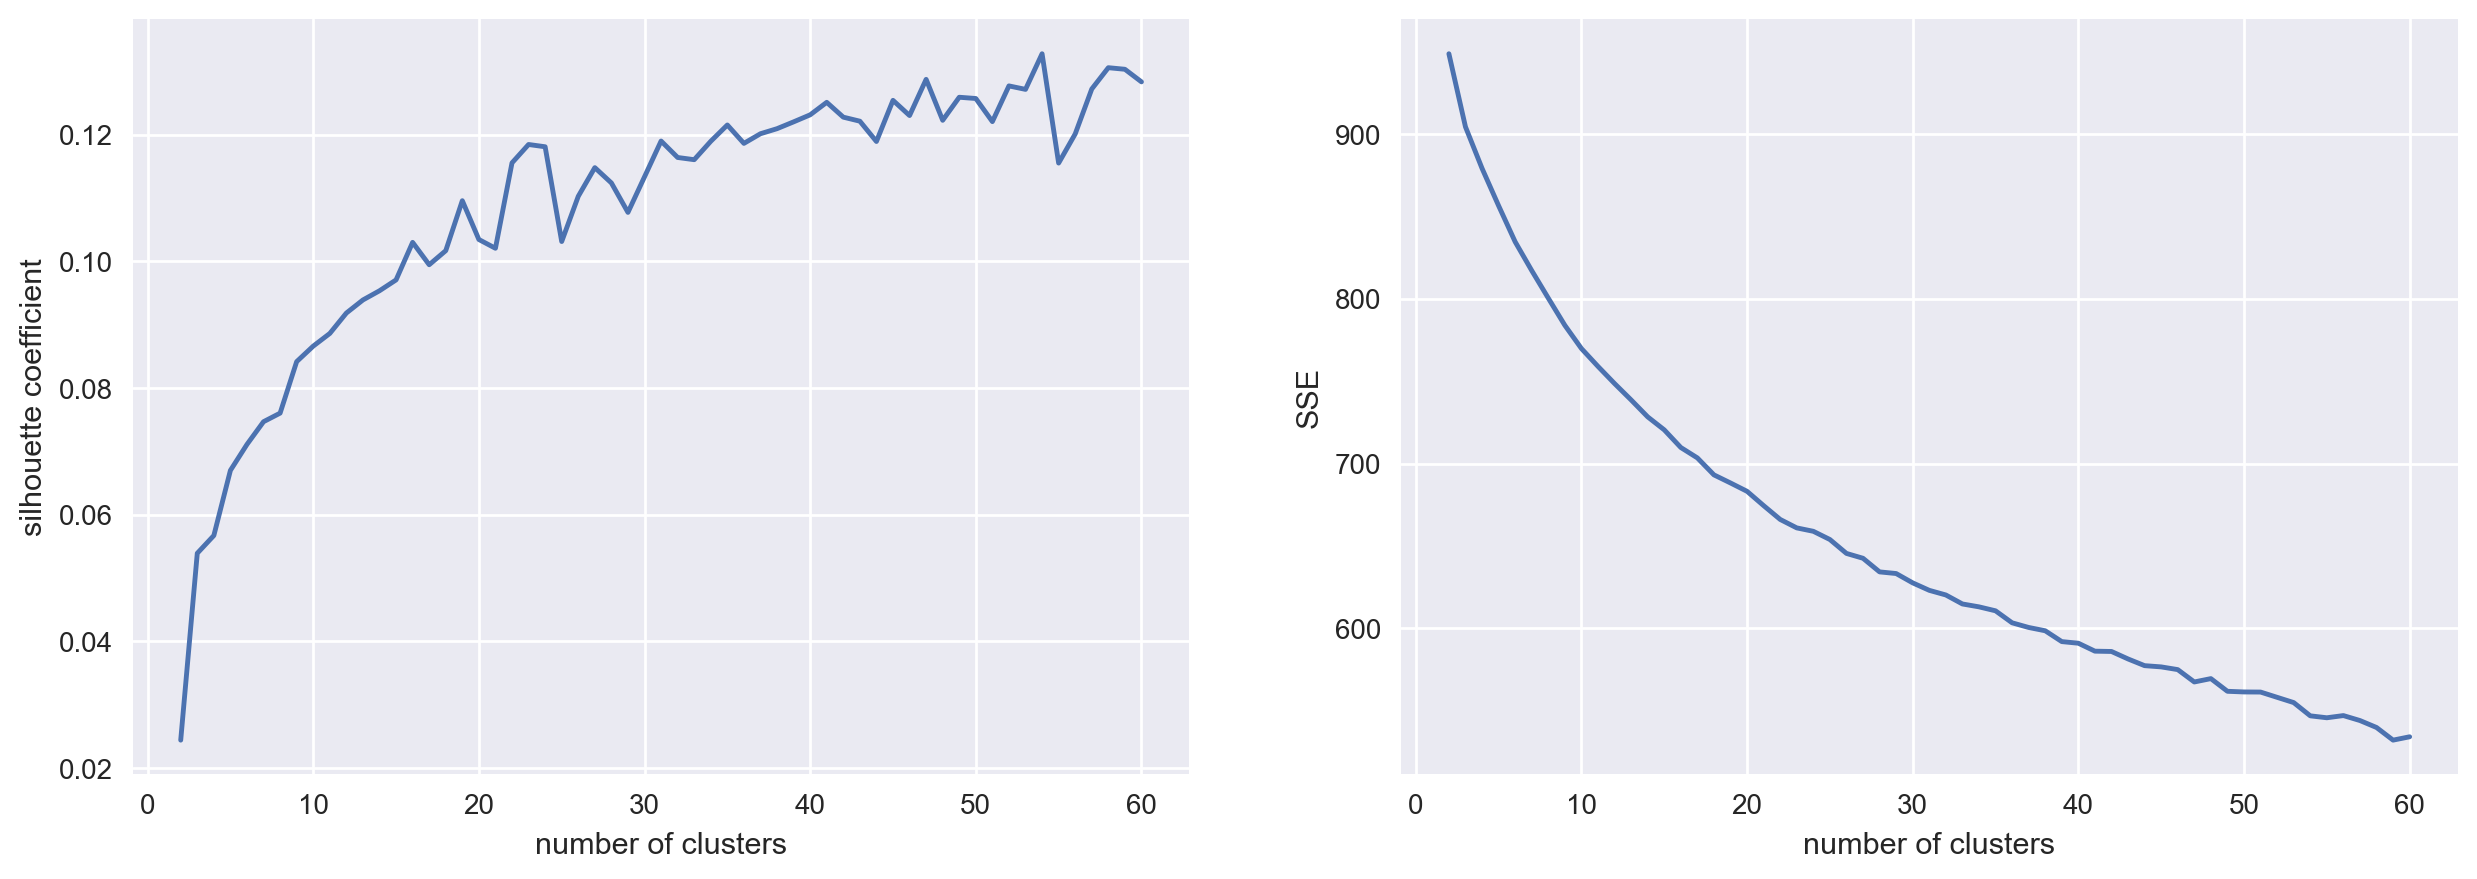

In [47]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True, dpi=200)
k_clusters = range(2,61)
ax1.plot(k_clusters, Sil_coefs)
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('silhouette coefficient')

# plot here on ax2
ax2.plot(k_clusters, SSEs)
ax2.set_xlabel('number of clusters')
ax2.set_ylabel('SSE');

In [48]:
km = KMeans(n_clusters=60)
clusts = km.fit_predict(corpus_lsa)

In [49]:
left_df['clusters'] = clusts

In [51]:
left_df.clusters.value_counts()

18    57
27    49
13    48
4     46
15    42
10    40
20    40
1     38
6     34
21    34
38    33
43    33
29    32
28    30
54    30
42    28
35    27
11    25
2     25
19    25
36    25
25    23
33    23
32    23
16    20
41    20
46    20
56    19
37    19
34    19
44    19
7     19
5     18
9     16
24    16
47    15
31    12
26    12
0     11
39    11
53    11
45    11
22    10
51    10
55     9
30     9
17     8
14     8
8      7
52     7
48     7
58     7
3      6
50     5
59     5
49     4
23     4
12     4
40     3
57     3
Name: clusters, dtype: int64

In [43]:
import os
os.system('say "Job\'s done."')

0

In [85]:
with open('left_cluster.pkl', 'wb') as picklefile:
        pickle.dump(left_df, picklefile)

## Right wing analysis

In [45]:
#stemmer = porter.PorterStemmer()
#stopwords = stopwords.words()

In [52]:
cleaned_text = clean_text(right_df.body)

In [53]:
right_corpus = drop_nouns(cleaned_text)

In [54]:
tfidf = TfidfVectorizer(ngram_range=(1, 2),  
                                   stop_words='english', 
                                   token_pattern="\\b[a-z][a-z]+\\b",
                                   lowercase=True,
                                   max_df = 0.6)
cor_tfidf = tfidf.fit_transform(right_corpus)

In [55]:
lsa = TruncatedSVD(60, algorithm = 'arpack')
corpus_lsa = lsa.fit_transform(cor_tfidf)
corpus_lsa = Normalizer(copy=False).fit_transform(corpus_lsa)

In [56]:
sum(lsa.explained_variance_ratio_)

0.13846625487692943

In [57]:
terms = tfidf.get_feature_names()

In [58]:
for i, comp in enumerate(lsa.components_):
    Terms_in_Comp = zip(terms,comp)
    sorted_Terms = sorted(Terms_in_Comp, key = lambda x: x[1], reverse=True) [:10]
    print("Topic %d:" %i)
    for term in sorted_Terms:
        print(term[0])
    print(" ")

Topic 0:
live
said
reserved
elect
choic relat
clip
clip choic
educ execut
elect tv
execut senat
 
Topic 1:
said
slotrenderended
say
make
think
read
told
know
read slotrenderended
wa
 
Topic 2:
slotrenderended
read slotrenderended
read
said read
april
say slotrenderended
april slotrenderended
don slotrenderended
won slotrenderended
best slotrenderended
 
Topic 3:
titl
slotrenderended
episode
episode title
finald
finald labelmapping
labelmapping
playlist
playlist episode
titl finald
 
Topic 4:
said
titl
said said
episode
episode title
finald
finald labelmapping
labelmapping
playlist
playlist episode
 
Topic 5:
breitbart reach
cur
cur weekli
weekli breitbart
writer
writer cur
weekli
breitbart
reach
hawkin
 
Topic 6:
slotrenderended
script
http
http script
test http
test
script slotrenderended
said
think
don
 
Topic 7:
april
april april
april slotrenderended
titl
read slotrenderended
script
http
http script
test http
test
 
Topic 8:
http
http script
test http
script
test
script slotrendere

In [59]:
SSEs = []
Sil_coefs = []
for k in range(2,61):
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(corpus_lsa)
    labels = km.labels_
    Sil_coefs.append(silhouette_score(corpus_lsa, labels, metric='euclidean'))
    SSEs.append(km.inertia_) 

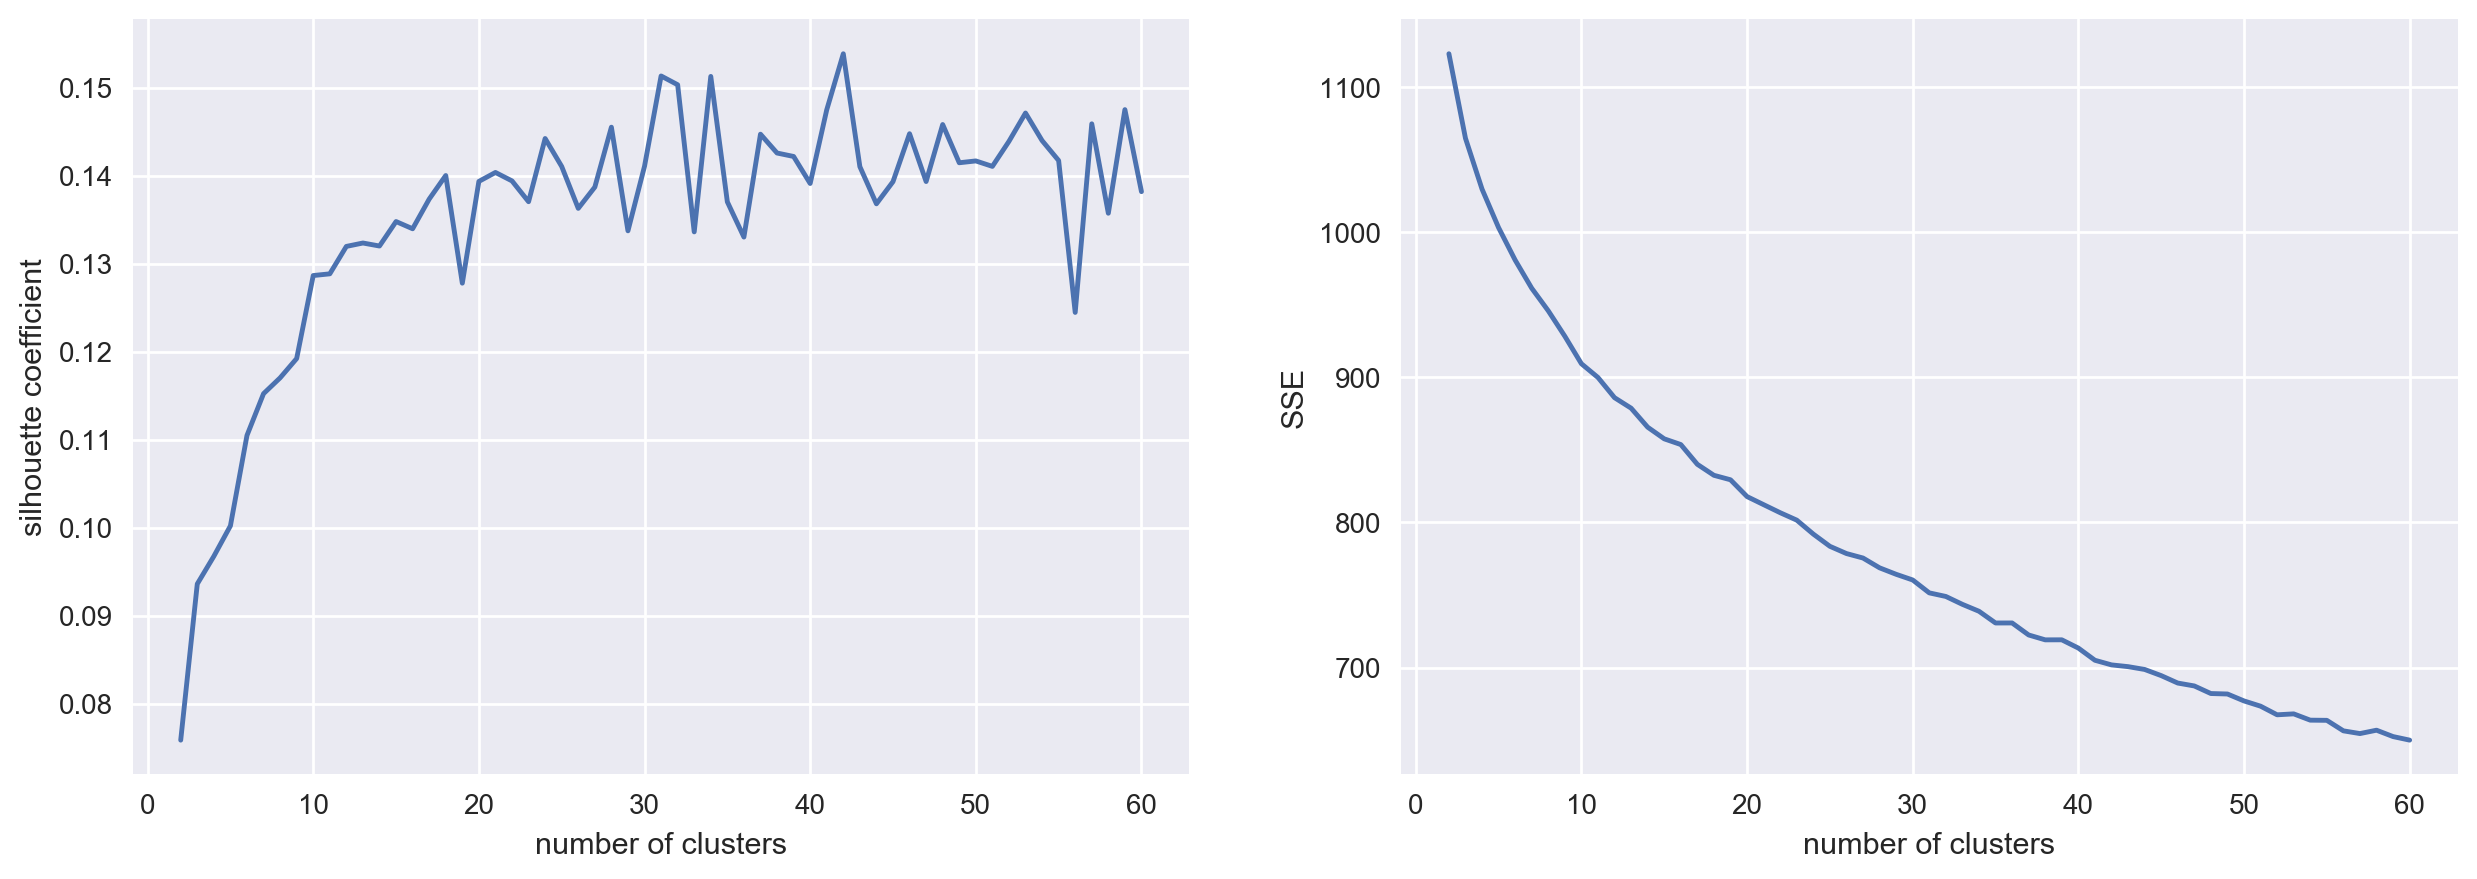

In [60]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True, dpi=200)
k_clusters = range(2,61)
ax1.plot(k_clusters, Sil_coefs)
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('silhouette coefficient')

# plot here on ax2
ax2.plot(k_clusters, SSEs)
ax2.set_xlabel('number of clusters')
ax2.set_ylabel('SSE');

In [61]:
km = KMeans(n_clusters=42)
clusts = km.fit_predict(corpus_lsa)

In [62]:
right_df['clusters'] = clusts

In [63]:
right_df.clusters.value_counts()

0     119
20     96
11     56
3      53
37     50
9      46
13     45
16     42
26     42
1      40
5      39
7      39
32     39
8      38
21     38
15     37
18     34
6      34
30     29
12     29
28     28
33     26
2      23
34     23
24     23
31     23
19     22
10     22
40     21
38     21
17     20
35     19
23     18
25     18
4      18
29     17
39     14
14     14
27     13
36     13
22     12
41      8
Name: clusters, dtype: int64

In [53]:
import os
os.system('say "Job\'s done."')

0

In [86]:
with open('right_cluster.pkl', 'wb') as picklefile:
        pickle.dump(right_df, picklefile)

## Center Analysis

In [64]:
cleaned_text = clean_text(center_df.body)

In [65]:
center_corpus = drop_nouns(cleaned_text)

In [66]:
tfidf = TfidfVectorizer(ngram_range=(1, 2),  
                                   stop_words='english', 
                                   token_pattern="\\b[a-z][a-z]+\\b",
                                   lowercase=True,
                                   max_df = 0.6)
cor_tfidf = tfidf.fit_transform(center_corpus)

In [67]:
lsa = TruncatedSVD(60, algorithm = 'arpack')
corpus_lsa = lsa.fit_transform(cor_tfidf)
corpus_lsa = Normalizer(copy=False).fit_transform(corpus_lsa)

In [68]:
sum(lsa.explained_variance_ratio_)

0.1551049994477012

In [69]:
terms = tfidf.get_feature_names()

In [70]:
for i, comp in enumerate(lsa.components_):
    Terms_in_Comp = zip(terms,comp)
    sorted_Terms = sorted(Terms_in_Comp, key = lambda x: x[1], reverse=True) [:10]
    print("Topic %d:" %i)
    for term in sorted_Terms:
        print(term[0])
    print(" ")

Topic 0:
left
required
atblog
lik
alabama
make
seek
russia
say russia
seek epa
 
Topic 1:
told
said said
trump
expect
wa
later
cohen
report
ask
set
 
Topic 2:
kay
alabama
requir
largest
amend
econom
develop
econom develop
email econom
ivey
 
Topic 3:
haspel
expect
democrat
confirm
make highest
set
expect make
elect
elect set
set remain
 
Topic 4:
requir
stop
elect
democrat
continu
requir sought
sought
cohen
paid
haspel
 
Topic 5:
haspel
confirm
said haspel
paid
cohen
haspel said
kay
senat
know
cia
 
Topic 6:
make highest
expect make
expect
elect set
set remain
elect
cohen
set
paid
democrat expect
 
Topic 7:
requir
stop
continu
requir sought
cohen
north
meet
sought
sponsor
haspel
 
Topic 8:
bozorgmehr
bozorgmehr sharafedin
sharafedin
say bozorgmehr
john
sharafedin john
sharafedin andrew
know
ali
ali say
 
Topic 9:
told
steve
defens
secretari
bozorgmehr
elect
said steve
trump
bozorgmehr sharafedin
sharafedin
 
Topic 10:
amend
steve
told
wa
elect
announc
nov make
nov
wa earlier
make say
 

In [71]:
SSEs = []
Sil_coefs = []
for k in range(2,61):
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(corpus_lsa)
    labels = km.labels_
    Sil_coefs.append(silhouette_score(corpus_lsa, labels, metric='euclidean'))
    SSEs.append(km.inertia_) 

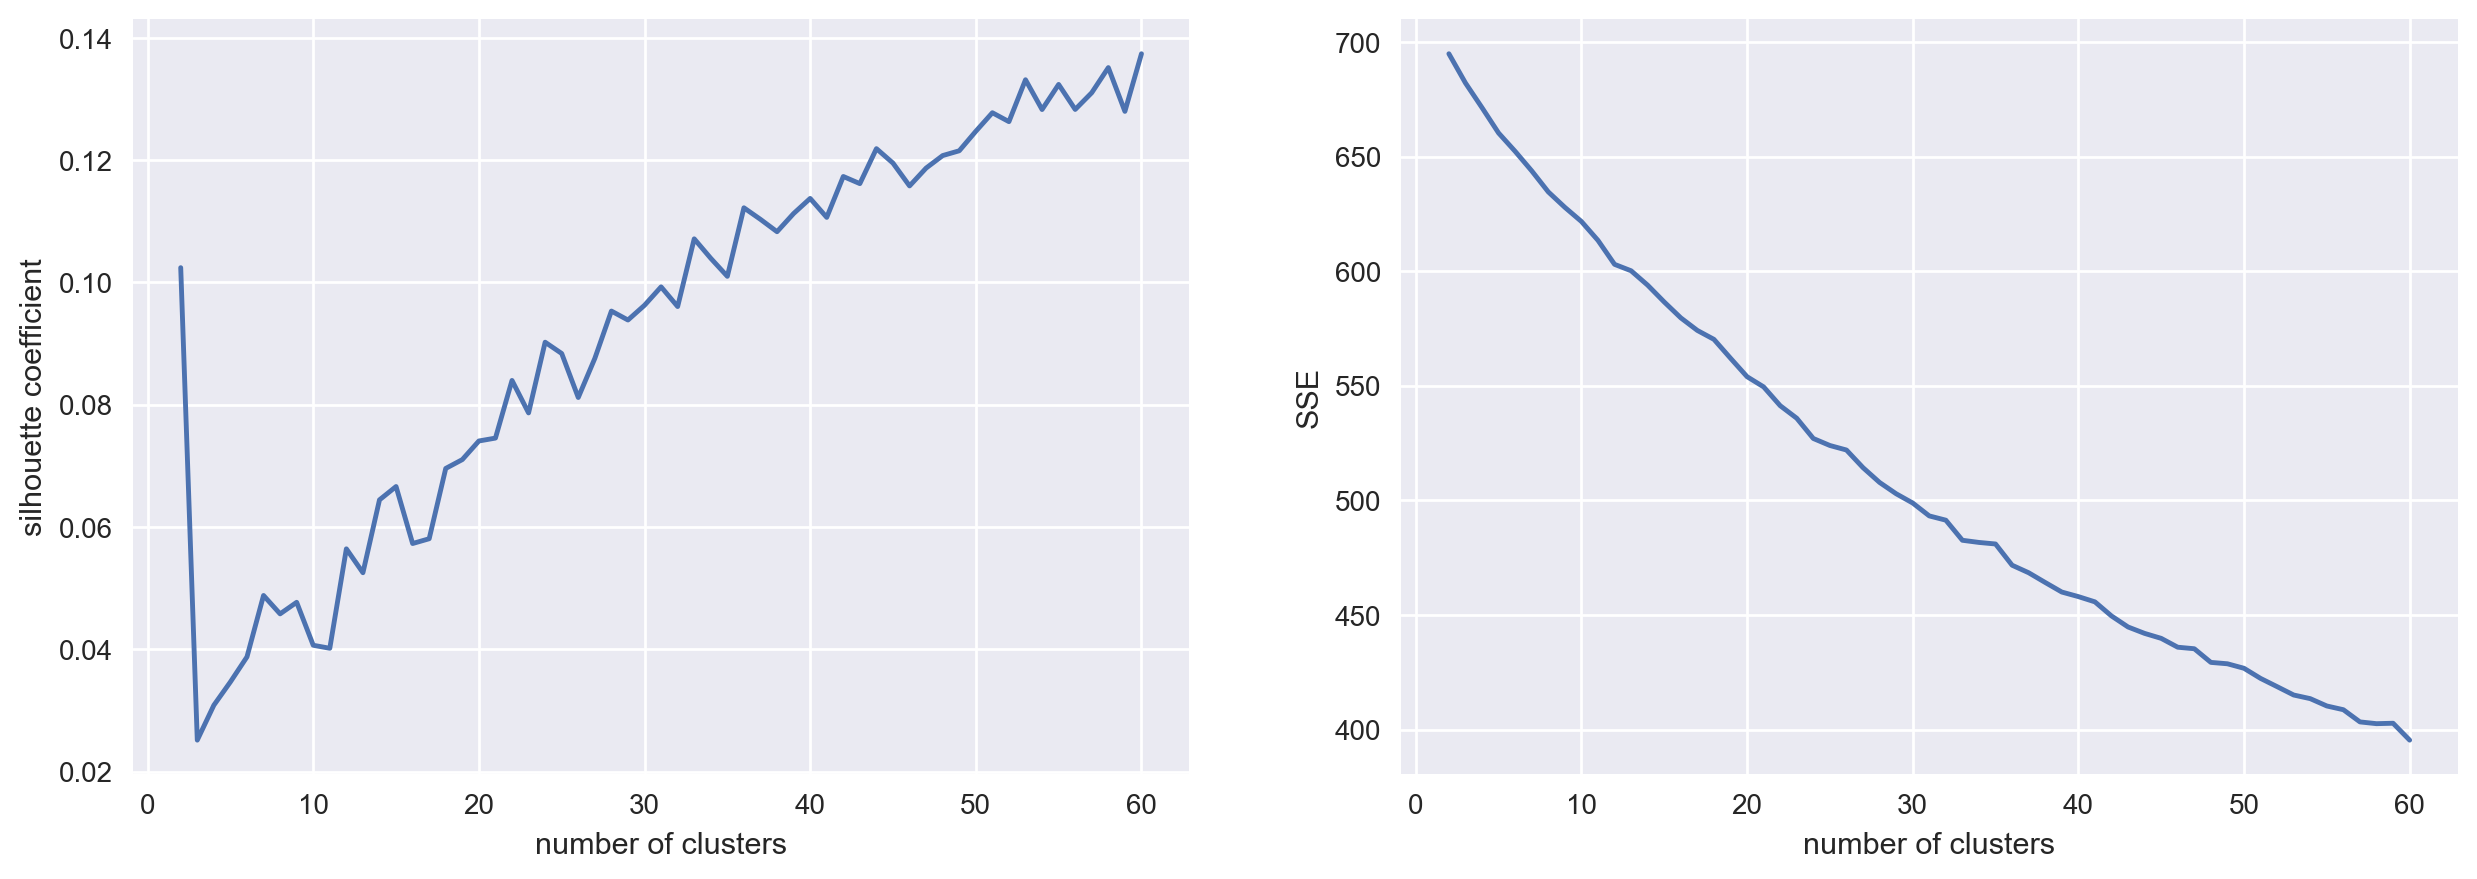

In [72]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True, dpi=200)
k_clusters = range(2,61)
ax1.plot(k_clusters, Sil_coefs)
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('silhouette coefficient')

# plot here on ax2
ax2.plot(k_clusters, SSEs)
ax2.set_xlabel('number of clusters')
ax2.set_ylabel('SSE');

In [73]:
km = KMeans(n_clusters=60)
clusts = km.fit_predict(corpus_lsa)

In [74]:
center_df['clusters'] = clusts

In [75]:
center_df.clusters.value_counts()

7     75
59    50
22    43
45    36
35    28
12    25
30    25
13    24
33    23
16    19
55    19
10    18
1     18
21    17
34    17
11    16
9     16
15    16
42    16
3     15
31    15
4     14
25    14
0     14
36    14
50    14
41    14
27    13
26    13
5     12
53    12
49    12
17    12
29    11
2     11
23    11
6     11
44    11
58    11
14    11
37    10
38    10
18    10
19    10
8     10
46     9
47     8
56     8
43     8
52     7
28     7
24     7
51     6
39     6
48     6
40     5
20     4
57     4
32     3
54     3
Name: clusters, dtype: int64

In [61]:
import os
os.system('say "Job\'s done."')

0

In [87]:
with open('center_cluster.pkl', 'wb') as picklefile:
        pickle.dump(center_df, picklefile)

## Conspiracy analysis

In [76]:
cleaned_text = clean_text(fake_df.body)

In [77]:
fake_corpus = drop_nouns(cleaned_text)

In [78]:
tfidf = TfidfVectorizer(ngram_range=(1, 2),  
                                   stop_words='english', 
                                   token_pattern="\\b[a-z][a-z]+\\b",
                                   lowercase=True,
                                   max_df = 0.6)
cor_tfidf = tfidf.fit_transform(fake_corpus)

In [79]:
lsa = TruncatedSVD(60, algorithm = 'arpack')
corpus_lsa = lsa.fit_transform(cor_tfidf)
corpus_lsa = Normalizer(copy=False).fit_transform(corpus_lsa)

In [80]:
sum(lsa.explained_variance_ratio_)

0.12580148716909817

In [81]:
terms = tfidf.get_feature_names()

In [82]:
for i, comp in enumerate(lsa.components_):
    Terms_in_Comp = zip(terms,comp)
    sorted_Terms = sorted(Terms_in_Comp, key = lambda x: x[1], reverse=True) [:10]
    print("Topic %d:" %i)
    for term in sorted_Terms:
        print(term[0])
    print(" ")

Topic 0:
said
depend
make
say
know
slotrenderended
wa
think
ani
told
 
Topic 1:
slotrenderended
read slotrenderended
read
said
april
say
told
said read
left
added
 
Topic 2:
slotrenderended
depend
adunit
adunit style
style
display
style display
email
previou
email previou
 
Topic 3:
know
make
don
don know
think
certif
amazon com
avail amazon
certif earli
com probe
 
Topic 4:
slotrenderended
http
http script
test http
script
script slotrenderended
test
wa
kill
west
 
Topic 5:
said
slotrenderended
think
electricsens
scientist
electricsens scientist
say
exposur
safer
said said
 
Topic 6:
electricsens
exposur
scientist
electricsens scientist
safer
caus
read slotrenderended
read
dr
scientist apocalyps
 
Topic 7:
april
http
http script
test http
script
script slotrenderended
test
read slotrenderended
read
april slotrenderended
 
Topic 8:
april
april slotrenderended
know
april april
wrote
stop
did
did april
say
fake
 
Topic 9:
adunit
adunit style
style
style display
display
bitcoin
display li

In [83]:
SSEs = []
Sil_coefs = []
for k in range(2,61):
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(corpus_lsa)
    labels = km.labels_
    Sil_coefs.append(silhouette_score(corpus_lsa, labels, metric='euclidean'))
    SSEs.append(km.inertia_) 

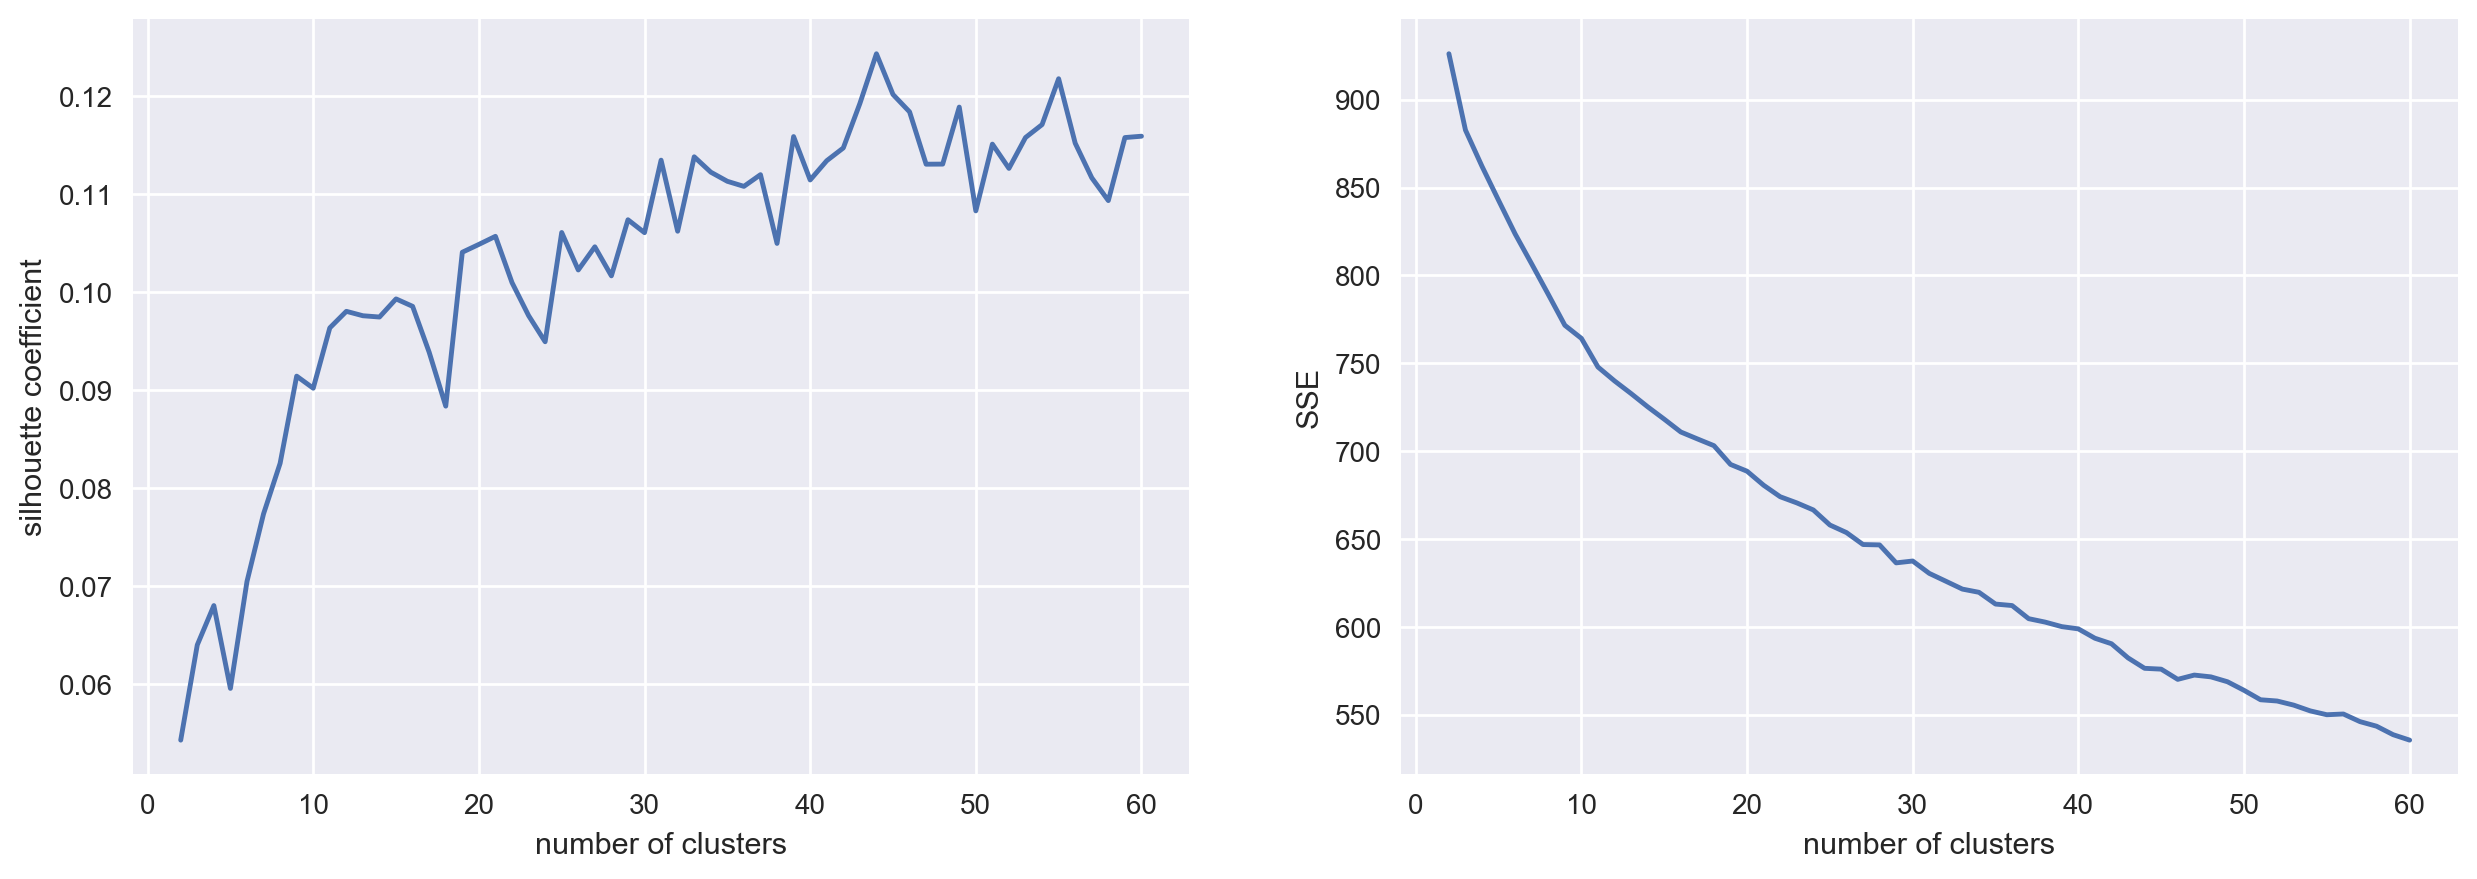

In [84]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True, dpi=200)
k_clusters = range(2,61)
ax1.plot(k_clusters, Sil_coefs)
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('silhouette coefficient')

# plot here on ax2
ax2.plot(k_clusters, SSEs)
ax2.set_xlabel('number of clusters')
ax2.set_ylabel('SSE');

In [88]:
km = KMeans(n_clusters=44)
clusts = km.fit_predict(corpus_lsa)

In [89]:
fake_df['clusters'] = clusts

In [90]:
fake_df.clusters.value_counts()

8     70
13    70
26    57
32    55
12    45
21    38
34    36
16    33
23    32
25    31
7     30
36    30
30    30
10    28
4     28
24    28
5     27
14    27
42    26
20    25
15    23
3     22
43    22
29    22
6     21
11    21
28    19
31    19
9     19
22    18
39    18
27    16
37    16
18    15
19    15
38    14
33    14
41    12
40    12
1     11
0     11
35     7
2      6
17     6
Name: clusters, dtype: int64

In [69]:
import os
os.system('say "Job\'s done."')

0

In [91]:
with open('fake_cluster.pkl', 'wb') as picklefile:
        pickle.dump(fake_df, picklefile)

In [3]:
ap_list_o_articles = pickle.load(open("pickle_files/ap_list_o_articles.pkl", "rb" ))


In [4]:
ap_list_o_articles[0]

{'title': 'Justices side with Colorado baker on same-sex wedding cake',
 'sub_title': 'filler',
 'body': '\n\n\n\n\n\n×\n\n\n\n\n\n\n\n\n\n\n              Baker Jack Phillips, owner of Masterpiece Cakeshop, manages his shop Monday, June 4, 2018, in Lakewood, Colo., after the U.S. Supreme Court ruled that he could refuse to make a wedding cake for a same-sex couple because of his religious beliefs did not violate Colorado\'s anti-discrimination law. (AP Photo/David Zalubowski)\n            \n\n\n\n\n\n\n              Charlie Craig, front, and David Mullins talk about a U.S. Supreme Court ruling that sets aside a Colorado court decision against a baker who would not make a wedding cake for the same-sex couple as they meet reporters Monday, June 4, 2018, in Denver. The Court has not decided on the larger issue in the case, however--whether a business can refuse to to serve gay and lesbian people. (AP Photo/David Zalubowski)\n            \n\n\n\n\n\n\n              Dave Mullins hugs a supp

In [8]:
book = [{'body': """Washington (CNN)President Donald Trump amplified his heated immigration rhetoric on Tuesday, accusing Democrats of wanting "illegal immigrants ... to pour into and infest our country," language evoking images of pests, not human beings.

"Democrats are the problem. They don't care about crime and want illegal immigrants, no matter how bad they may be, to pour into and infest our Country, like MS-13. They can't win on their terrible policies, so they view them as potential voters!" he wrote.

Donald J. Trump
✔
@realDonaldTrump
 Democrats are the problem. They don’t care about crime and want illegal immigrants, no matter how bad they may be, to pour into and infest our Country, like MS-13. They can’t win on their terrible policies, so they view them as potential voters!

8:52 AM - Jun 19, 2018
49.5K
38.7K people are talking about this
Twitter Ads info and privacy
The President's Twitter language further escalated his dehumanizing rhetoric amid a developing humanitarian -- and political -- crisis on the United States' border with Mexico, where at least 2,000 children have been separated from their parents as a result of the administration's policy.
Why Trump is digging in on separating families at the border
Why Trump is digging in on separating families at the border
Last month, the administration publicly announced its decision to charge every adult caught crossing the border illegally with federal crimes, as opposed to referring those with children mainly to immigration courts, as previous administrations did.
Because the government is charging the parents in the criminal justice system, children are separated from them, with no clear procedure for their reunification aside from hotlines the parents can call to try to track their children down.
In the past weeks, heartbreaking images and audio of children crying for their parents have captured the nation's attention as lawmakers seek to find a solution to end the separations and the White House doubles down on its insistence that it is simply enforcing the law.
Trump's hardline immigration rhetoric was a central piece of his campaign rallying cries, beginning with his campaign announcement speech in June 2015.
"When Mexico sends its people, they're not sending their best. ... They're sending people that have lots of problems, and they're bringing those problems with us. They're bringing drugs. They're bringing crime. They're rapists. And some, I assume, are good people," Trump said at the time.
CNN's Tal Kopan contributed to this report."""}]

In [9]:
book_df = pd.DataFrame.from_dict(book)

In [10]:
book_df

,body
0,Washington (CNN)President Donald Trump amplifi...


In [13]:
true_book_df = pd.concat([true_df, book_df])

In [15]:
true_book_df.tail()

,body,num_source,source,title
228,\n\n\nFox News\n\n\n\n\n\n\n\n\n\n\nU.S.\nWorl...,7.0,Fox News,"Conservative groups, congressional Republicans..."
230,\n\n\nFox News\n\n\n\n\n\n\n\n\n\n\nU.S.\nWorl...,7.0,Fox News,Dems struggling to flip key California House s...
232,\n\n\nFox News\n\n\n\n\n\n\n\n\n\n\nU.S.\nWorl...,7.0,Fox News,"Blackburn, Bredesen lead candidates vying for ..."
234,\n\n\nFox News\n\n\n\n\n\n\n\n\n\n\nU.S.\nWorl...,7.0,Fox News,"Former Obama official, liberal activists share..."
0,Washington (CNN)President Donald Trump amplifi...,NaN,NaN,NaN
